### NivLink Demo: Multidimensional Decision-Making Task

This demo uses data from a multidimensional decision-making paradigm similar to the one described in: 

> Leong, Y. C., Radulescu, A., Daniel, R., Dewoskin, V., Niv, Y. (2017). Dynamic Interaction between Reinforcement Learning and Attention in Multidimensional Environments. _Neuron_, 93(2), 451–463. http://doi.org/10.1016/j.neuron.2016.12.040

On every trial of the task, participants choose between three column stimuli which vary along three dimensions: faces, houses and tools. Upon choosing a column, they either receive a reward or not, presented as a green or red rectangle around the chosen column. After a variable delay, the features in each column reshuffle along each dimension, and the next trial begins.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as io
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
from nivlink import ScreenInfo
from nivlink import epoching_fht, align_to_aoi, compute_fixations

sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#### Load eye-tracking data.

Refer to [DataViewer documentation](https://github.com/nivlab/NivLink/blob/master/docs/DataViewer.Md) for details on how to generate raw text files for your experiment. 


In [2]:
## Load single subject data from text file.
et_data_path = 'sample_eyetrack_data.txt'
raw_data = pd.read_table(et_data_path);

## Filter out columns of interest, convert to array and replace '.' with NaNs.
raw_data_lean = raw_data.filter(['SAMPLE_MESSAGE','RIGHT_GAZE_X','RIGHT_GAZE_Y'], axis=1)
raw_data_lean = raw_data_lean.replace('.',np.nan)
raw_data_array = raw_data_lean.values

#### Load behavioral data.

Here, we're loading the corresponding RTs for each trial.

In [3]:
behavior = read_csv('sample_behav_data.csv',index_col=0)
behavior.head(5)

,Trial,RT
1,1,NaN
2,2,0.84760
3,3,0.86708
4,4,1.25670
5,5,1.00550


#### Load pre-generated events file.

The events file is a 3-column `.mat` file with line per trial which defines:  

- The run number (here, "run" refers to a continuous chunk of time during which the eye-tracker was recording) 
- The trial onset relative to when the eye-tracker started recording on this run
- The trial duration

In [4]:
events_file_path = 'sample_events.mat'
events_mat = io.loadmat(events_file_path)
events = np.array(events_mat["events_array"])

#### Load pre-generated feature map file.

The feature map file is a n_trial by n_aoi with one line per trial which defines the task feature corresponding to each Area of Interest (AoI). 

In [5]:
featmap_file_path = 'sample_featmap.mat'
featmap_mat = io.loadmat(featmap_file_path)
featmap = np.array(featmap_mat["features_aoi_map"])

#### Define screen parameters.

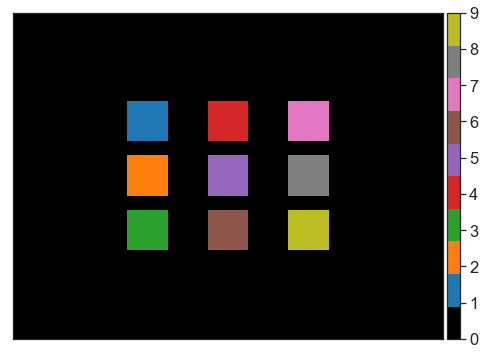

In [6]:
## Define metadata.
xdim, ydim, sfreq = 1600, 1200, 500

## Initialize ScreenInfo object.
info = ScreenInfo(xdim, ydim, sfreq, )

## Define and add areas of interest.
n_aois = 9
aois = np.empty((n_aois,2,2))

# Left column
aois[0] = np.matrix([[425, 325], [575, 475]])
aois[1] = np.matrix([[425, 525], [575, 675]])
aois[2] = np.matrix([[425, 725], [575, 875]])

# Middle column
aois[3] = np.matrix([[725, 325], [875, 475]])
aois[4] = np.matrix([[725, 525], [875, 675]])
aois[5] = np.matrix([[725, 725], [875, 875]])

# Right column
aois[6] = np.matrix([[1025, 325], [1175, 475]])
aois[7] = np.matrix([[1025, 525], [1175, 675]])
aois[8] = np.matrix([[1025, 725], [1175, 875]])

for a in range(0, n_aois):
    info.add_rectangle_aoi(aois[a,0,0], aois[a,1,0], aois[a,0,1], aois[a,1,1])
        
## Visually inspect AoIs. 
fig, ax = info.plot_aoi(1,6,False,)

#### Preprocess.

In [7]:
## Run epoching. 
epochs = epoching_fht(raw_data_array, info, events)

## Define screenidx array.
n_trials = max(behavior.Trial) 
# In this demo, AoIs are identically distributed across trials
screenidx = np.ones((n_trials,1)) 

## Align to AoI. 
aligned = align_to_aoi(epochs, info, screenidx)

## Compute fixations. 
fixations = compute_fixations(aligned, info)

## Add screen column.
fixations['Screen'] = screenidx[fixations.Trial.values.astype(int) - 1].astype(int)

## If applicable, re-label AoIs.

## Map to task features. 
fixations['Feature'] = featmap[fixations.Trial.values.astype(int) - 1,fixations.AoI.values.astype(int) - 1]
fixations.head(10)

TypeError: align_to_aoi() takes 2 positional arguments but 3 were given

#### Run some basic QA checks.

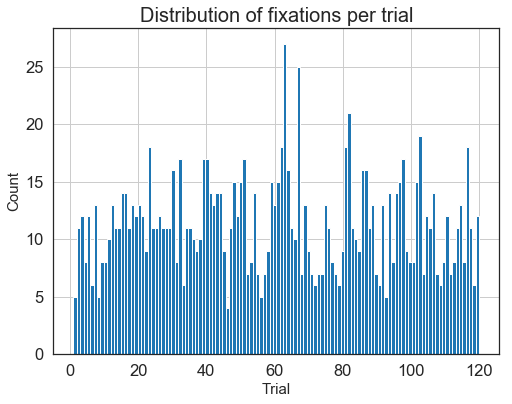

In [9]:
fixations.hist('Trial',bins=120,figsize=[8,6])
plt.xlabel('Trial',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Distribution of fixations per trial',fontsize=20);

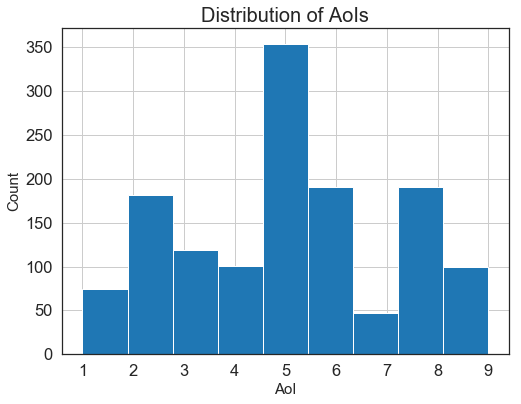

In [10]:
fixations.hist('AoI',bins=9,figsize=[8,6])
plt.xlabel('AoI',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Distribution of AoIs',fontsize=20);

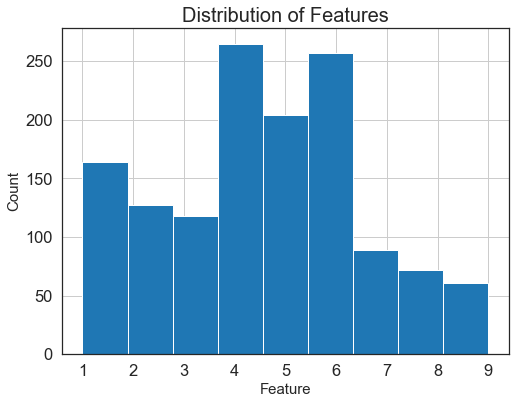

In [11]:
fixations.hist('Feature',bins=9,figsize=[8,6])
plt.xlabel('Feature',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Distribution of Features',fontsize=20);

#### Visualize mapping for a single trial.

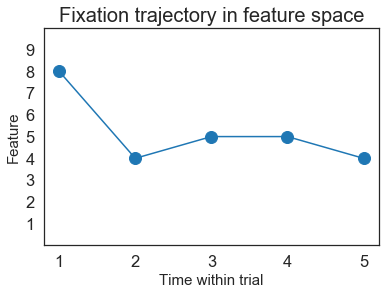

In [11]:
## Select trial.
t = 1
fixations_this_trial = fixations.loc[fixations['Trial'] == t]
[n_events, dummy] = fixations_this_trial.shape

## Plot trajectory in feature space.
plt.plot(np.arange(1, n_events+1, step=1), fixations_this_trial.Feature.values, '-o',markersize=12)
plt.xlabel('Time within trial',fontsize=15)
plt.ylabel('Feature',fontsize=15)
plt.ylim((0,10))
plt.xticks(np.arange(1, n_events+1, step=1))
plt.yticks(np.arange(1, 10, step=1))
plt.title('Fixation trajectory in feature space',fontsize=20);

#### Pandas Example 1: Merge fixations and behavior dataframes along trial number. 

In [12]:
data = pd.merge(fixations, behavior, on ='Trial')
data.head(10)

,Trial,AoI,Onset,Offset,Duration,Feature,RT
0,1.0,1.0,0.408,0.610,0.202,8,NaN
1,1.0,5.0,0.824,1.192,0.368,4,NaN
2,1.0,8.0,1.208,1.438,0.230,5,NaN
3,1.0,8.0,1.624,1.954,0.330,5,NaN
4,1.0,5.0,1.970,4.000,2.030,4,NaN
5,2.0,5.0,0.000,0.648,0.648,6,0.8476
6,2.0,2.0,0.662,0.854,0.192,5,0.8476
7,2.0,5.0,0.868,0.868,0.000,6,0.8476
8,2.0,5.0,1.246,2.616,1.370,6,0.8476
9,2.0,8.0,2.632,2.972,0.340,4,0.8476


#### Pandas Example 2: Remove fixations lasting less than 100ms.

In [13]:
data = data[data.Duration >= 0.10].reset_index(drop=True)

#### Pandas Example 3: Remove fixations after response.

In [18]:
## Drop missing responses, fast responses.
data = data.dropna()
data = data[data.RT > 0.2]

## Realign fixations to response.
data.Onset -= data.RT
data.Offset -= data.RT

## Remove fixations beginning after response.
data = data[data.Onset < 0]
data.head(10)

,Trial,AoI,Onset,Offset,Duration,Feature,RT
5,2.0,5.0,-0.84760,-0.19960,0.648,6,0.84760
6,2.0,2.0,-0.18560,0.00640,0.192,5,0.84760
13,3.0,5.0,-0.86708,-0.50508,0.362,6,0.86708
14,3.0,2.0,-0.48508,0.30492,0.790,5,0.86708
20,4.0,5.0,-1.25670,-0.82870,0.428,6,1.25670
21,4.0,2.0,-0.80870,-0.49470,0.314,5,1.25670
22,4.0,5.0,-0.48070,-0.34870,0.132,6,1.25670
23,4.0,8.0,-0.33670,1.07130,1.408,4,1.25670
27,5.0,5.0,-1.00550,1.28050,2.286,6,1.00550
34,6.0,5.0,-0.92680,1.63320,2.560,4,0.92680
